# Hyperparameter

In [1]:
ROOT = "/srv/data/VQA_Dataset"
NLP_MODEL = "distilbert-base-uncased"
IMAGE_SHAPE= (200, 350)
BATCH_SIZE = 16
WEIGHTS_PATH="./temp_weights.h"

# Libraries

In [2]:
import os
import json
import numpy as np
from cache_decorator import Cache
from tqdm.auto import tqdm
from skimage.io import imread
from skimage.transform import resize
from transformers import pipeline, AutoTokenizer, TFAutoModel
import multiprocessing as mp
from sklearn.model_selection import ShuffleSplit

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

# Import Keras 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import TerminateOnNaN, CSVLogger

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



# Data loading

In [4]:
features_extraction_pipeline = pipeline(
    'feature-extraction', 
    model=NLP_MODEL, 
    tokenizer=NLP_MODEL,
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

In [5]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [6]:
def parse_img(path):
    img = imread(os.path.join(ROOT, "Images/{}.png".format(path)))
    img = resize(img, IMAGE_SHAPE)
    # remove the alpha
    return img[:,:,:3]

In [7]:
def chunks(data, chunk_size=64):
    while data != []:
        data, chunk = data[chunk_size:], data[:chunk_size]
        yield chunk

In [8]:
@Cache("/tmp/cache/embed_questions/{NLP_MODEL}/{_hash}.pkl")
def embed_questions(questions, NLP_MODEL, chunk_size=64):
    return [
        pred
        for question in tqdm(
            chunks(questions, chunk_size), 
            desc="Embedding the questions",
            leave=False,
            total=int(len(questions)/chunk_size)
        )
        for pred in np.array(features_extraction_pipeline(
            question,
            # padding="max_length", 
            # max_length=10,
        ))
    ]

def aggregate_questions(questions):
    return [
        np.average(np.array(q), axis=0)
        for q in tqdm(
            embed_questions(questions, NLP_MODEL), 
            desc="Aggregating the questions",
            leave=False
        )
    ]

In [9]:
def parse_json(path, train=True):
    with open(path) as f:
        questions = json.load(f)
    if train:
        y = [
            to_categorical(labels_dict[val["answer"]], num_classes=len(labels_dict))
            for val in tqdm(questions.values(), desc="Loading labels", leave=False)
            ]
    else:
        y = list(questions.keys())
        
    imgs = [
            val["image_id"]
            for val in tqdm(questions.values(), desc="Loading the images",leave=False)
    ]
    
    questions = [
        val["question"].lower()
        for val in tqdm(questions.values(), desc="Loading the questions",leave=False)
    ]
    
    questions = aggregate_questions(questions)
    
    return np.array(imgs), np.array(questions), np.array(y)

In [10]:
%%time
imgs, questions, y = parse_json("VQA_Dataset/train_questions_annotations.json")

CPU times: user 47min 16s, sys: 2min 16s, total: 49min 32s
Wall time: 4min 4s


In [11]:
class DataSequence(Sequence):

    def __init__(self, imgs, questions, answers, batch_size=BATCH_SIZE):
        self.questions = np.array(questions)
        self.answers = np.array(answers)
        self.batch_size = batch_size
        self.imgs = np.array(imgs)

    def __len__(self):
        return int(np.ceil(len(self.questions) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch
        indices = np.arange(len(self.questions))
        np.random.shuffle(indices)
        self.answers = self.answers[indices]
        self.questions = self.questions[indices]
        self.imgs = self.imgs[indices]
    
    def __getitem__(self, idx):
        # Load lazily the data from the disk
        start = idx * self.batch_size
        end   = (idx + 1) * self.batch_size
        
        imgs = self.imgs[start:end]
        
        imgs = [
            parse_img(img)
            for img in imgs
        ]
        
        questions = self.questions[start:end]
        answers = self.answers[start:end]
            
        return (np.array(questions), np.array(imgs)), answers

In [12]:
split = ShuffleSplit(test_size=0.2, random_state=0xc0febabe)
train_indices, val_indices = next(split.split(questions))

In [13]:
train_imgs = imgs[train_indices]
train_questions = questions[train_indices]
train_y = y[train_indices]

val_imgs = imgs[val_indices]
val_questions = questions[val_indices]
val_y = y[val_indices]

In [14]:
train = DataSequence(train_imgs, train_questions, train_y)
val = DataSequence(val_imgs, val_questions, val_y)

# Model

In [15]:
image_input = Input(shape=(*IMAGE_SHAPE, 3), name="image")

vision_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=image_input
)

encoded_image = Flatten()(vision_model.output)

In [16]:
bert_question = Input(shape=(768,), name="question")

In [17]:
# Combine CNN and Bert Self-Attention to create the final model
h = Concatenate()([bert_question, encoded_image])
h = Dense(128, kernel_initializer=tf.keras.initializers.GlorotNormal())(h)
output = Dense(len(labels_dict), activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal())(h)

In [18]:
vqa_model = Model(inputs=[bert_question, image_input], outputs=output)

In [19]:
vqa_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=["accuracy"],
)

In [20]:
vqa_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 350, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 174, 32)  864         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 174, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 99, 174, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training

In [22]:
train[0]

((array([[-0.11104035, -0.27501124,  0.09947611, ..., -0.15522637,
           0.19936728, -0.06869281],
         [-0.01079184, -0.32867091,  0.11269615, ..., -0.12433852,
           0.19427523, -0.18451218],
         [-0.00802471, -0.08395726, -0.03223117, ...,  0.06770247,
           0.01171275,  0.08817604],
         ...,
         [ 0.03654959, -0.08014043, -0.04108339, ...,  0.05489839,
           0.13453599,  0.06295047],
         [-0.14036532, -0.10426998,  0.02384887, ..., -0.0070338 ,
           0.20230742, -0.12953913],
         [-0.10360439,  0.01702701,  0.09759549, ...,  0.08768651,
           0.20277441, -0.11561616]]),
  array([[[[0.83529412, 0.98039216, 0.99607843],
           [0.83529412, 0.98039216, 0.99607843],
           [0.83529412, 0.98039216, 0.99607843],
           ...,
           [0.83529412, 0.98039216, 0.99607843],
           [0.83529412, 0.98039216, 0.99607843],
           [0.83529412, 0.98039216, 0.99607843]],
  
          [[0.82745098, 0.98039216, 0.99607843

In [23]:
vqa_model.fit(
    train, 
    steps_per_epoch=len(train), 
    validation_data=val,
    validation_steps=len(val),
    epochs=100,
    callbacks=[
        ReduceLROnPlateau(),
        TerminateOnNaN(),
        CSVLogger("./train_log.csv"),
        EarlyStopping(
            monitor="val_loss",
            patience=4, restore_best_weights=True
        ),
    ]
)

Epoch 1/100
2942/2942 [==============================] - 7814s 3s/step - loss: 1.5687 - accuracy: 0.4890 - val_loss: 1.1422 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 2/100
2942/2942 [==============================] - 7799s 3s/step - loss: 1.1332 - accuracy: 0.5493 - val_loss: 1.0553 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 3/100
2942/2942 [==============================] - 7802s 3s/step - loss: 1.0099 - accuracy: 0.5710 - val_loss: 1.0224 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 4/100
2942/2942 [==============================] - 7804s 3s/step - loss: 0.9813 - accuracy: 0.5784 - val_loss: 0.9920 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 5/100
2942/2942 [==============================] - 7810s 3s/step - loss: 0.9620 - accuracy: 0.5861 - val_loss: 1.0076 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 6/100
2942/2942 [==============================] - 7804s 3s/step - loss: 1.0084 - accuracy: 0.5805 - val_loss: 1.0255 - val_accuracy: 0.5582 - lr: 0.0010
Epoch 7/100
2942/2942 [=================

In [24]:
vqa_model.save_weights(WEIGHTS_PATH)

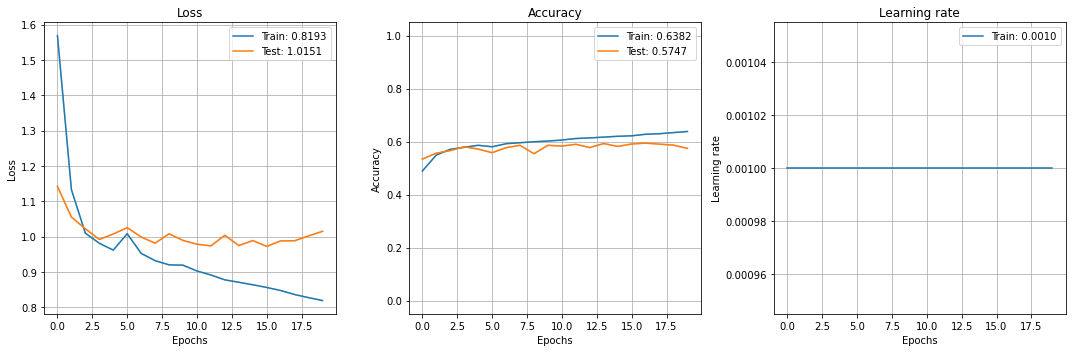

In [36]:
from plot_keras_history import plot_history
history = Out[23]
plot_history(history.history)

# Test

In [37]:
%%time
test_imgs, test_questions, ids = parse_json("VQA_Dataset/test_questions.json", train=False)

CPU times: user 4min 49s, sys: 4.26 s, total: 4min 53s
Wall time: 23.8 s


In [38]:
class TestSequence(Sequence):

    def __init__(self, imgs, questions, batch_size=BATCH_SIZE):
        self.questions = np.array(questions)
        self.batch_size = batch_size
        self.imgs = np.array(imgs)

    def __len__(self):
        return int(np.ceil(len(self.questions) / self.batch_size))

    def __getitem__(self, idx):
        # Load lazily the data from the disk
        start = idx * self.batch_size
        end   = (idx + 1) * self.batch_size
        
        imgs = self.imgs[start:end]
        
        imgs = [
            parse_img(img)
            for img in imgs
        ]
        
        questions = self.questions[start:end]
            
        return (np.array(questions), np.array(imgs))

In [39]:
test = TestSequence(test_imgs, test_questions, batch_size=BATCH_SIZE)

In [40]:
reverse_labels_dict = {v:k for k, v in labels_dict.items()}

In [41]:
%%time
submission = dict(zip(ids, [
    reverse_labels_dict[np.argmax(pred)]
    for i in tqdm(range(len(test)), leave=False)
    for pred in vqa_model.predict(test[i])
]))

CPU times: user 53min 18s, sys: 35.5 s, total: 53min 53s
Wall time: 4min 45s


In [42]:
with open("./predictions.csv", "w") as f:
    f.write("Id,Category\n")
    for vals in submission.items():
        f.write("{},{}\n".format(*vals)) 

# Checking the results

In [43]:
import matplotlib.pyplot as plt

In [44]:
with open("VQA_Dataset/test_questions.json") as f:
    test_questions = json.load(f)

In [45]:
ROWS, COLUMNS = 10, 10
submission_list = list(submission.items())

<ipython-input-46-41009e3c10da>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


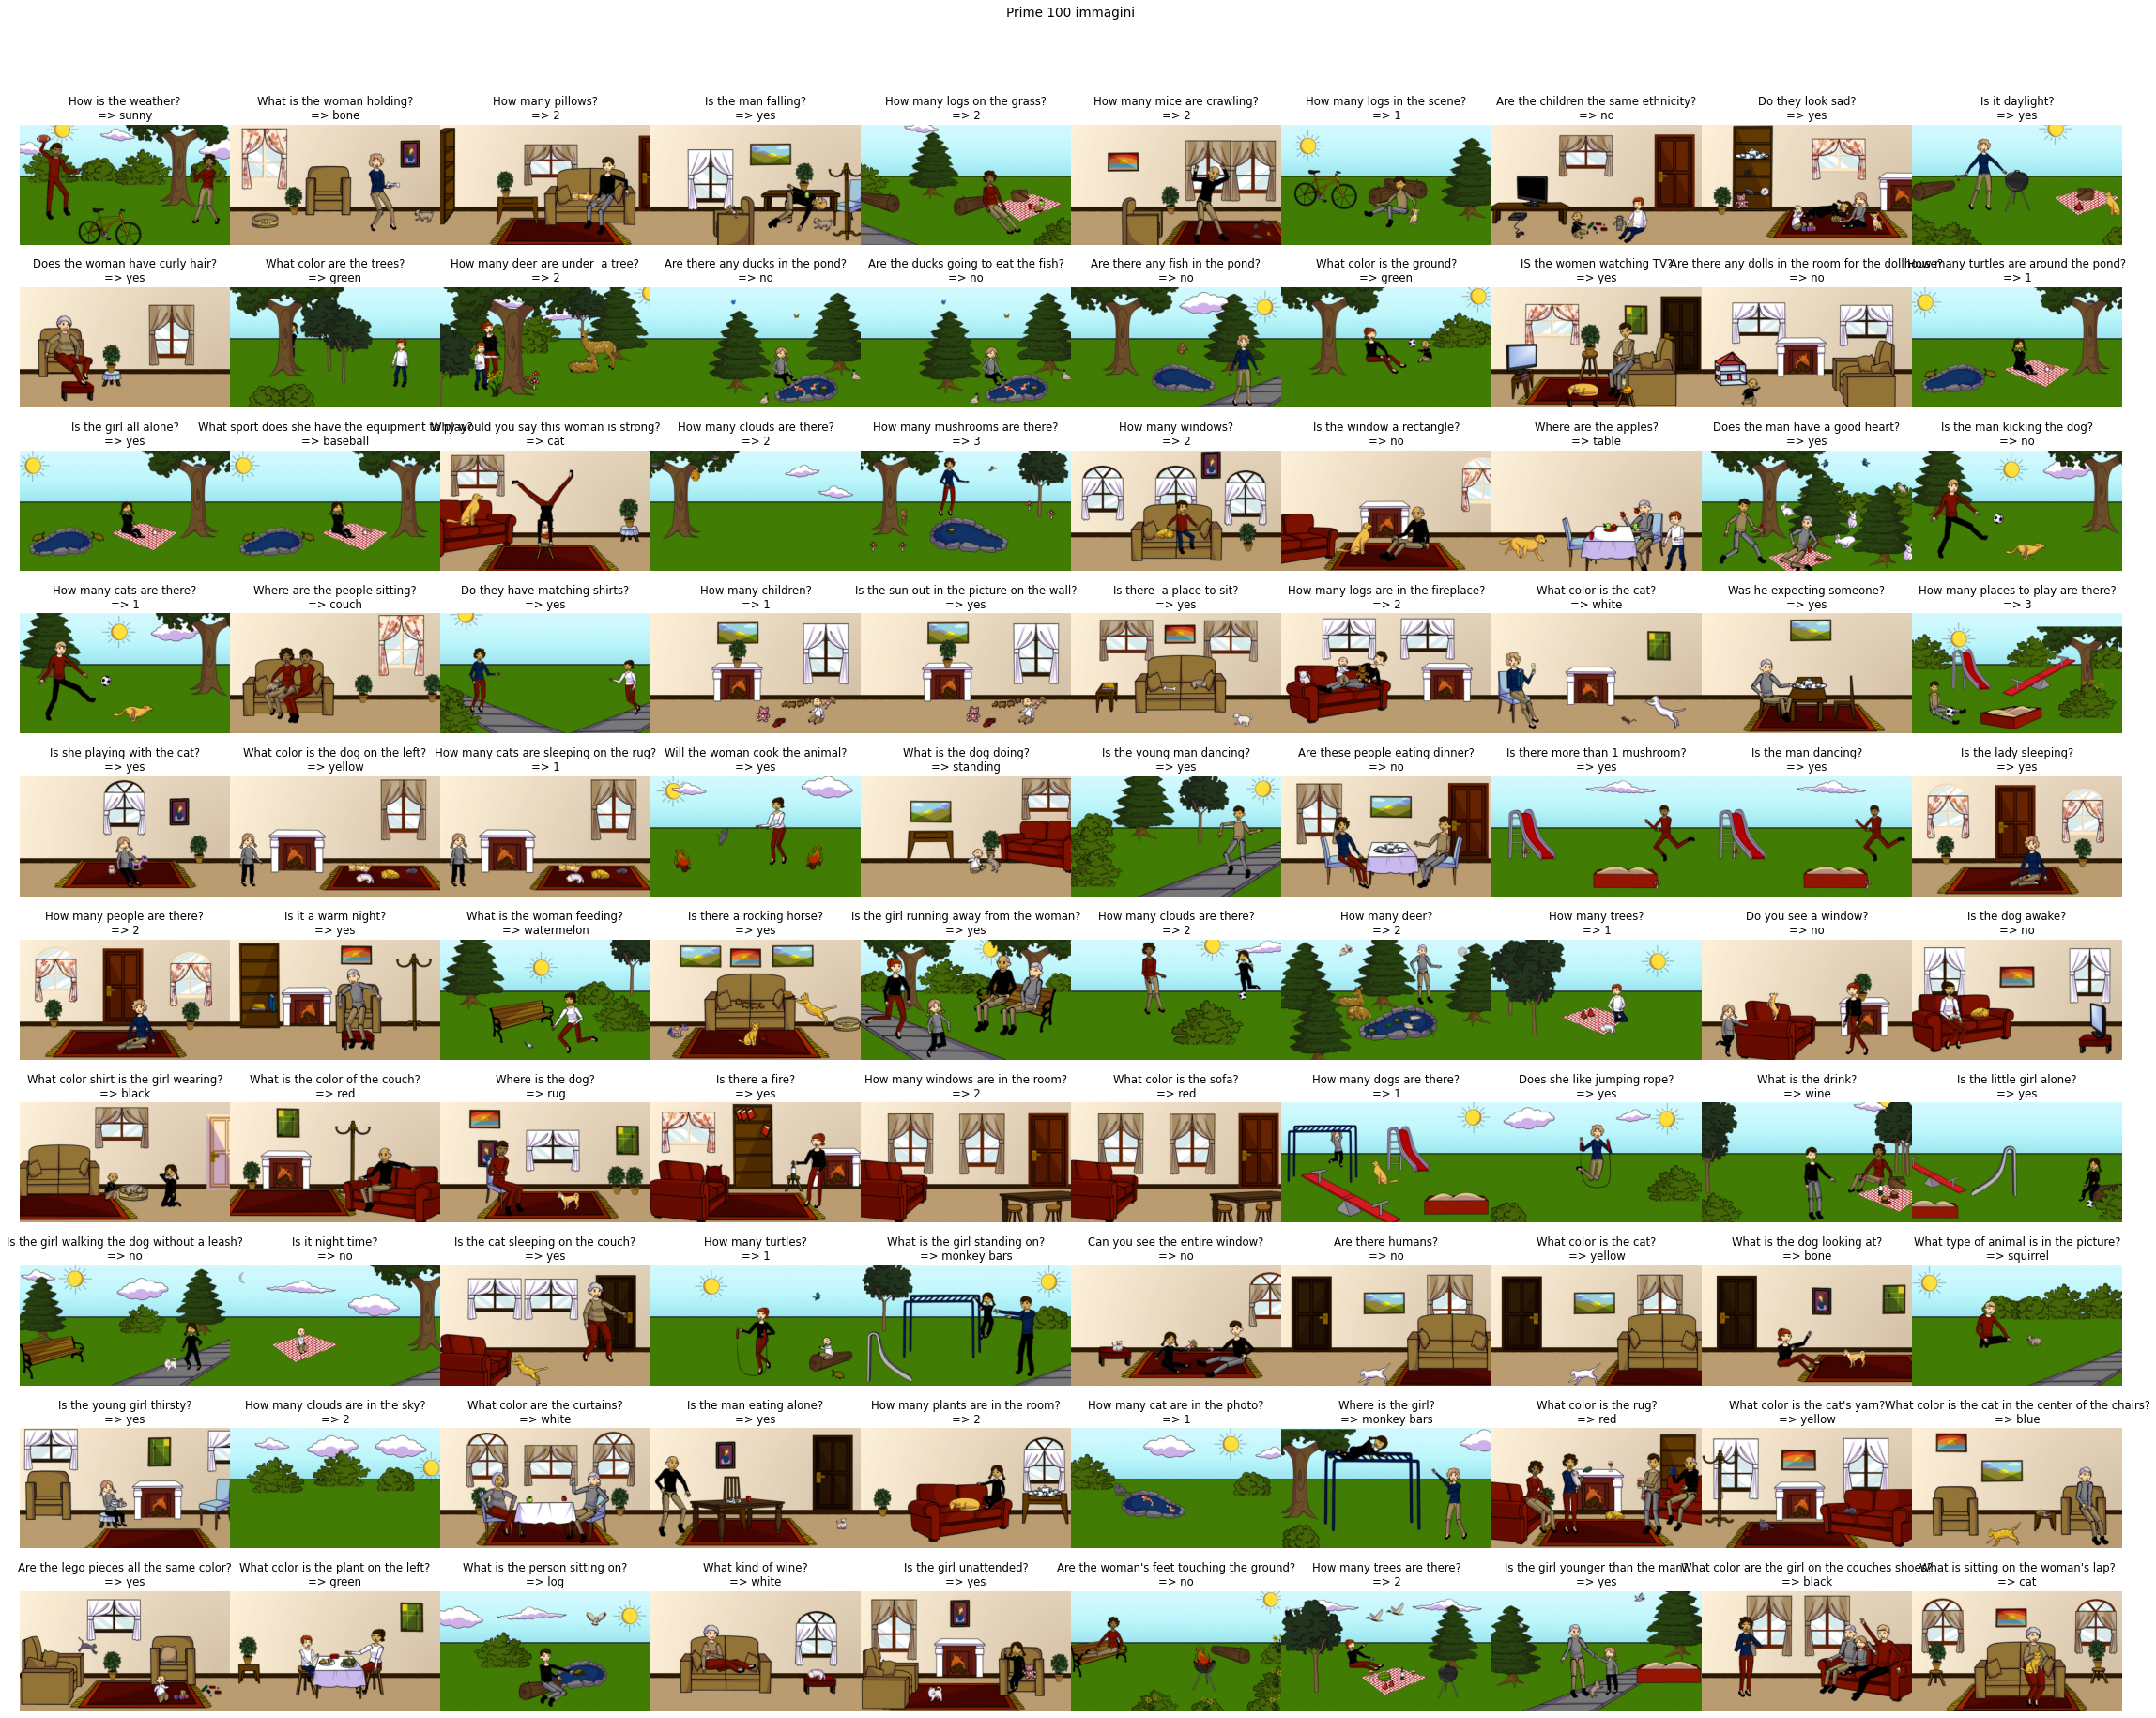

In [46]:
fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(32, 25), dpi=70, subplot_kw={'xticks': [], 'yticks': []})
for (i, a) in enumerate(axes):
    for (j, ax) in enumerate(a):
            num = i * COLUMNS + j
            _id, pred = submission_list[num]
            val = test_questions[_id]
            ax.imshow(parse_img(val["image_id"]))
            ax.set_title("{0}\n=> {1}".format(val["question"], pred))
            ax.set(frame_on=False)

fig.tight_layout(pad=0)
fig.suptitle("Prime 100 immagini", fontsize=14, y=1.05)
fig.patch.set_facecolor('white')
fig.show()